In [ ]:
# import some packages
import numpy as np
import matplotlib.pyplot as plt

# Path to images
im_pth = "../data/images/"

img_list = [
    'M0616C002000.jpg',
    'M0630C049000.jpg',
    'M0633C028000.jpg',
    'M0630C042000.jpg',
    'M0571C038000.jpg',
    'M0631C027000.jpg',
    'M0714C026000.jpg',
    'M0640C051000.jpg'
]

non_defective = [
    'M0377C017010.jpg', 
    'Bent Cure 0Pa TestName_20201222_165250.586_C034.jpg'
]

In [2]:
def plot_imgs(img_array, img_labels):
    
    #Plot OK
    n = len(img_array)
    # Work out the number of rows
    n_rows = int((n / 2) if (n % 2 == 0) else ((n + 1) / 2))

    fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(8,8))

    if n_rows == 1:
        for i in range(n):
            axs[i].set_title(img_labels[i])
            axs[i].imshow(img_array[i])

    else:
        k=0
        for i in range(n_rows):
            for j in range(2):
                axs[i][j].set_title(img_labels[k])
                axs[i][j].imshow(img_array[k])
                k += 1

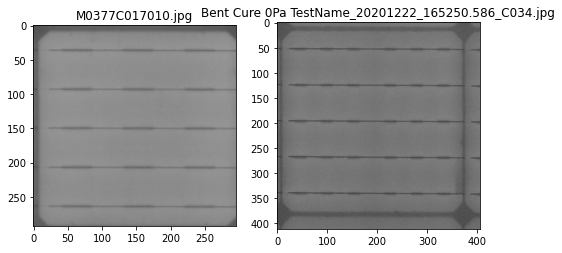

In [3]:
# Load files
img_array_ok = [plt.imread(f'{im_pth}'+i) for i in non_defective]
img_array_defected = [plt.imread(f'{im_pth}'+i) for i in img_list]

#Plot OK
plot_imgs(img_array_ok, non_defective)

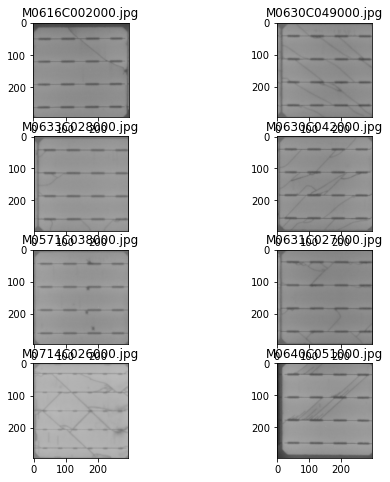

In [4]:
#Plot Defected
plot_imgs(img_array_defected, img_list)

In [5]:
# Apply some standard filters

import cv2

from scipy.ndimage import convolve
from scipy import signal

In [56]:
# Display the fft and the image
def display_fft(in_img, title, log=False, fixed_range=False):
    
  # fourier image
    [ydim, xdim] = in_img.shape
    win = np.outer(np.hanning(ydim), np.hanning(xdim))
    win = win/np.mean(win)

  # fourier image
    F = np.fft.fftshift(np.fft.fft2(in_img*win))
    Fmag = np.abs(F)
    Fmag[Fmag < 0.01] = 0.01
  
  # Display results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

  # Display image
    if fixed_range:
        axes[0].imshow(in_img, vmin=0, vmax=1, cmap=plt.cm.gray)
    else:
        axes[0].imshow(in_img, cmap=plt.cm.gray)
        axes[0].set_axis_off()
        axes[0].set_title('Input Image')

    if log:
        axes[1].imshow(np.log(Fmag), cmap=plt.cm.gray)
    else:
        axes[1].imshow(Fmag, cmap=plt.cm.gray)
        axes[1].set_axis_off()
        axes[1].set_title('Fourier Magnitude')

    plt.suptitle(f'{title}')
    plt.show()  

# Create a radial mask
def create_mask(in_rad, shape, mtype):
    
  # Create a vertical mask
    if mtype == 'vertical':
        in_mask = np.zeros(shape)
        midpoint = in_mask.shape[1] // 2
        top_left = (midpoint-in_rad, 0)
        bottom_right = (midpoint+in_rad, shape[0])
        cv2.rectangle(in_mask, top_left, bottom_right, (255, 255, 255), -1)[0]
        in_mask = in_mask / 255
        
    
  # create circle mask

    elif mytpe == 'circle':
        in_mask = np.zeros(shape)
        cy = in_mask.shape[0] // 2
        cx = in_mask.shape[1] // 2
        cv2.circle(in_mask, (cx,cy), in_rad, (255, 255, 255), -1)[0]
        in_mask = in_mask / 255

  # blur the mask
    mask2 = cv2.GaussianBlur(in_mask, (15, 15), 10.5, cv2.BORDER_DEFAULT)

    return mask2

# Apply a mask to the FFT image
def mask_fft(in_img, mask):
            
    F = np.fft.fftshift(np.fft.fft2(in_img))
    Fmag = np.abs(F) * mask
  
  # the ifft assume the incoming fft is shifted to the center of the image
    combined = np.fft.ifftshift(np.multiply(Fmag, np.exp(1j * np.angle(F))))
    imgCombined = np.real(np.fft.ifft2(combined))
  
    return imgCombined

# Create a Gaussian of a specific size
def create_2d_gaussian(size=9, std=1.5):

    gaussian_1d = signal.gaussian(size, std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d / (gaussian_2d.sum())

    return gaussian_2d

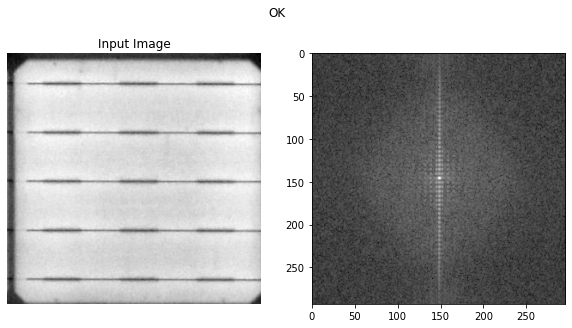

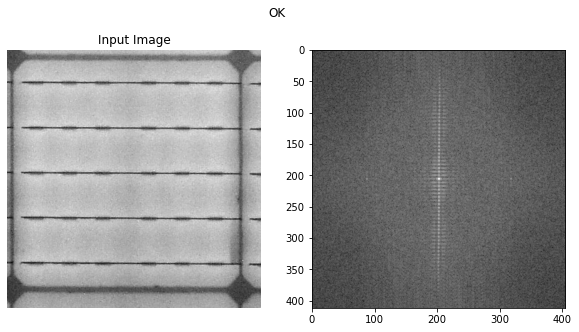

In [57]:
from skimage.color import rgb2gray

for img in img_array_ok:
    display_fft(rgb2gray(img), 'OK', log=True)

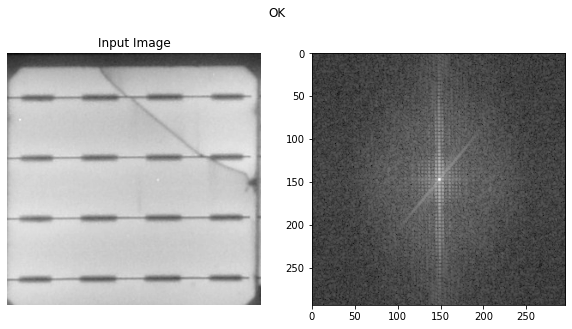

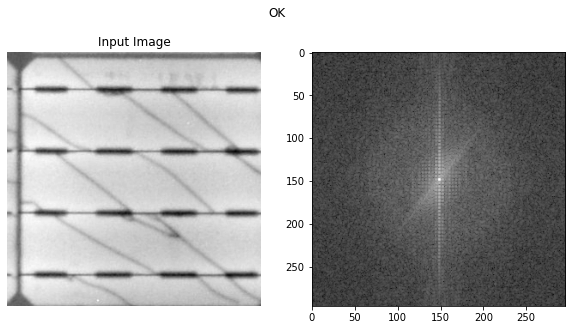

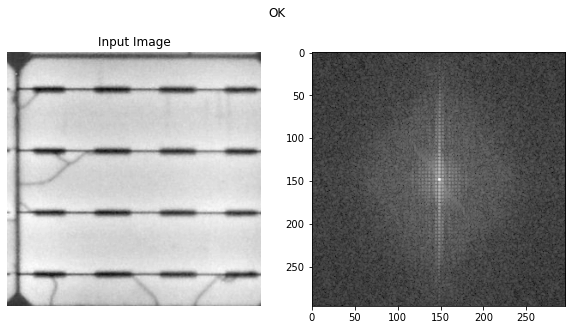

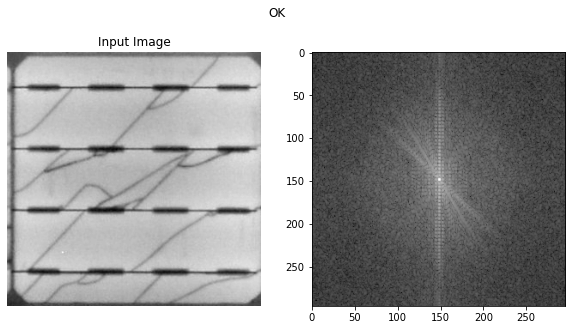

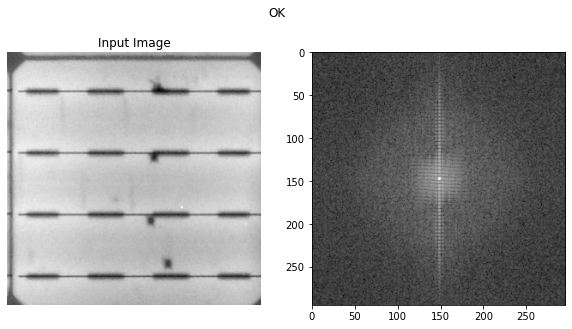

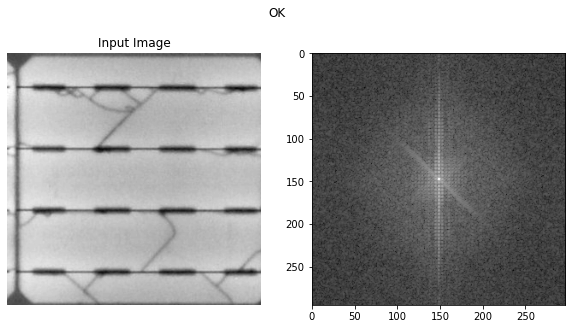

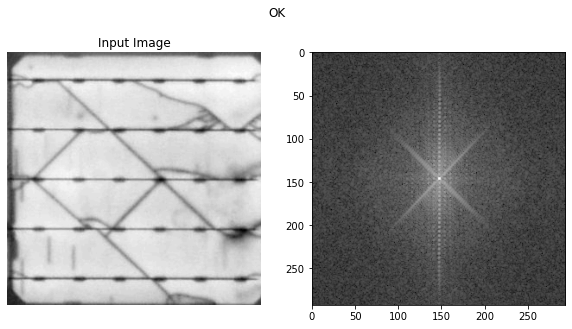

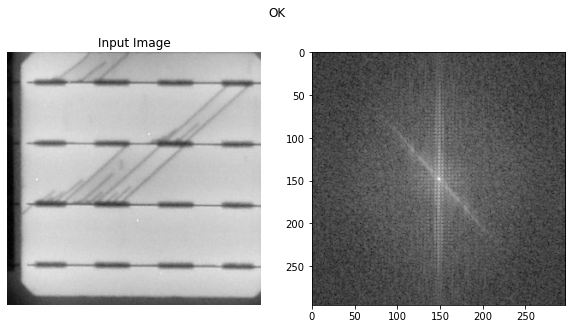

In [58]:
for img in img_array_defected:
    display_fft(rgb2gray(img), 'OK', log=True)

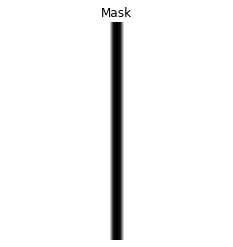

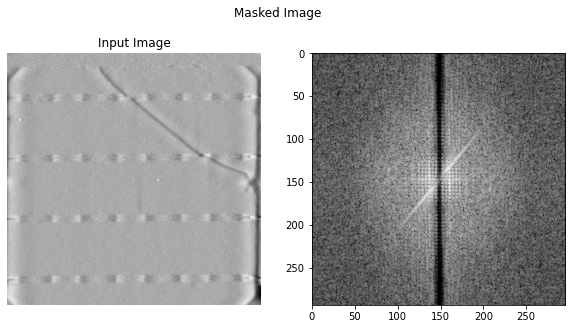

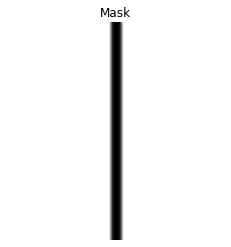

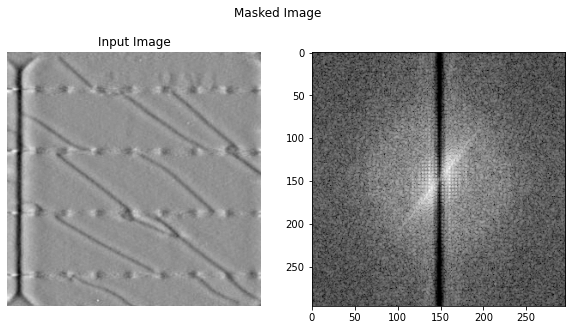

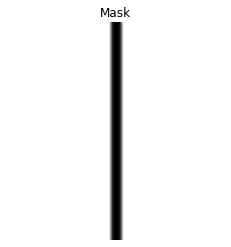

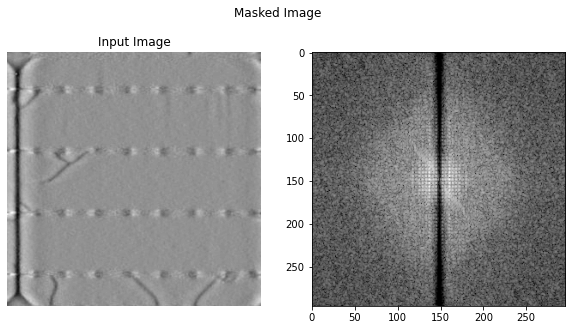

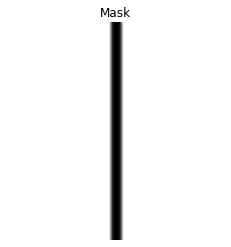

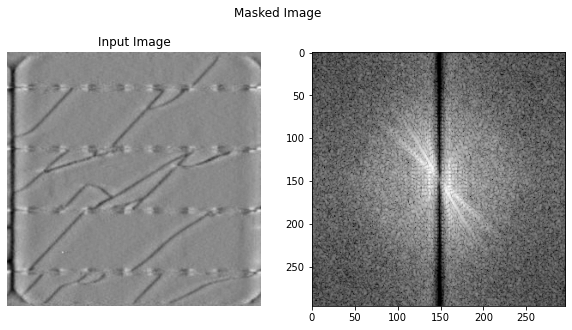

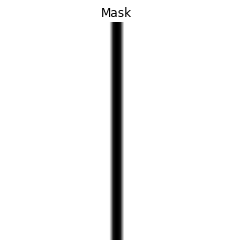

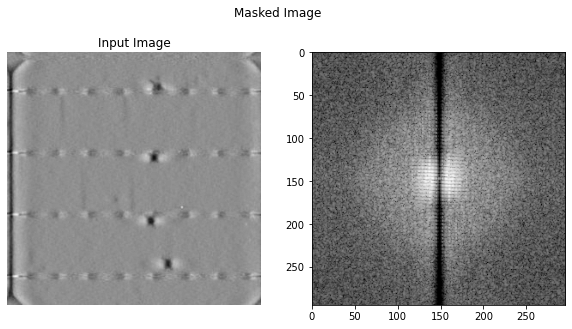

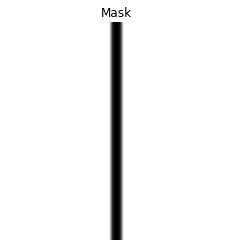

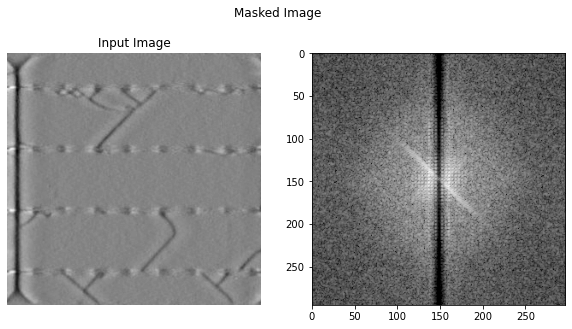

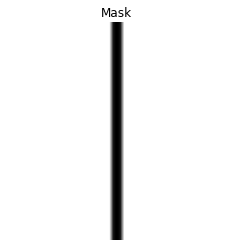

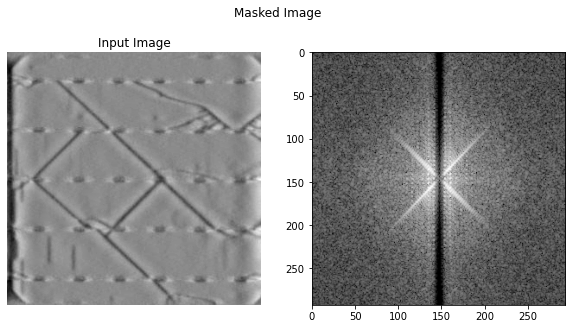

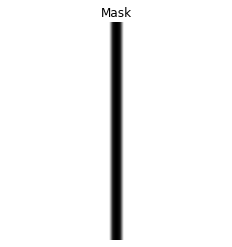

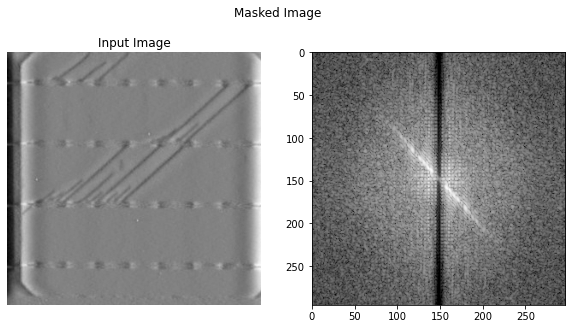

In [60]:
for img in img_array_defected:
    
    # with a radius defined in pixels
    mask = np.max(mask) - create_mask(2, rgb2gray(img).shape, 'vertical')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Mask')
    plt.show()

    # apply the mask to the fft of the image
    masked_image = mask_fft(rgb2gray(img), mask)
    display_fft(masked_image, 'Masked Image', log=True)